In [1]:
import os
os.chdir("/content/drive/MyDrive/boaz/Eyu/Edu datasets")

In [2]:
!ls

 Educ			       EyuEdu_Labels_11CLASS.npy
'Educations .ipynb'	       EyuEdu_Labels.npy
'EDU model develop.ipynb'      EYUEDU_model.h5
 EyuEdu_Features_11CLASS.npy  'EYUEDU Training and validation Accuracy.png'
 EyuEdu_Features.npy	      'EYUEDU Training and validation loss.png'


In [3]:
!pip install efficientnet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import shutil

In [5]:
Data_Dir = "/content/drive/MyDrive/boaz/Eyu/Edu datasets/Educ"
categories = ['Butterfly', 'Car[Automotive]', 'Cat', 'Chess', 'Chicken', 'Cow', 'Dog', 'Elephant', 'Food', 
              'Horse', 'Sheep']
Image_size = 224

In [6]:
data = np.load("/content/drive/MyDrive/boaz/Eyu/Edu datasets/EyuEdu_Features_11CLASS.npy")
Labels = np.load("/content/drive/MyDrive/boaz/Eyu/Edu datasets/EyuEdu_Labels_11CLASS.npy")

In [7]:
data = data/255.0

In [8]:
data.shape

(5558, 224, 224, 3)

In [9]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

labelb = LabelBinarizer()
Lables = labelb.fit_transform(Labels)
Labels = to_categorical(Labels) 

In [10]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(data, Labels, train_size = 0.9, stratify = Labels, random_state = 42)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.05,
                                   shear_range = 0.2,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   fill_mode = "nearest")

In [12]:
import efficientnet.keras as efn
from keras.layers import Dense, AveragePooling2D, Input, Dropout, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix

baseModel = efn.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(Image_size, Image_size, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(11, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [14]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

[INFO] compiling model...
[INFO] training head...


In [15]:
his = model.fit_generator(
    train_datagen.flow(train_X, train_Y, batch_size= BS),
    steps_per_epoch=len(train_X) // BS,
    validation_data=(test_X, test_Y),
    validation_steps=len(test_X) // BS,
    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
156/156 [==============================] - 70s 346ms/step - loss: 0.4805 - accuracy: 0.3450 - val_loss: 0.1950 - val_accuracy: 0.8993
Epoch 2/50
156/156 [==============================] - 52s 332ms/step - loss: 0.1686 - accuracy: 0.8280 - val_loss: 0.1035 - val_accuracy: 0.9442
Epoch 3/50
156/156 [==============================] - 51s 330ms/step - loss: 0.1006 - accuracy: 0.9031 - val_loss: 0.0692 - val_accuracy: 0.9496
Epoch 4/50
156/156 [==============================] - 52s 331ms/step - loss: 0.0776 - accuracy: 0.9150 - val_loss: 0.0528 - val_accuracy: 0.9622
Epoch 5/50
156/156 [==============================] - 51s 328ms/step - loss: 0.0652 - accuracy: 0.9205 - val_loss: 0.0436 - val_accuracy: 0.9622
Epoch 6/50
156/156 [==============================] - 51s 327ms/step - loss: 0.0543 - accuracy: 0.9276 - val_loss: 0.0377 - val_accuracy: 0.9622
Epoch 7/50
156/156 [==============================] - 51s 328ms/step - loss: 0.0496 - accuracy: 0.9259 - val_loss: 0.0336 - val_ac

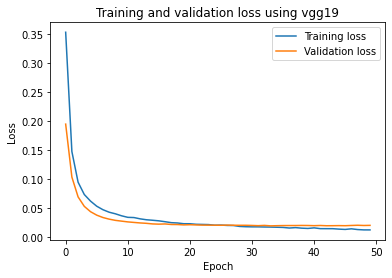

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(his.history["loss"], label='Training loss')
plt.plot(his.history["val_loss"], label='Validation loss')
plt.title('Training and validation loss using vgg19')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("EYUEDU Training and validation loss.png")

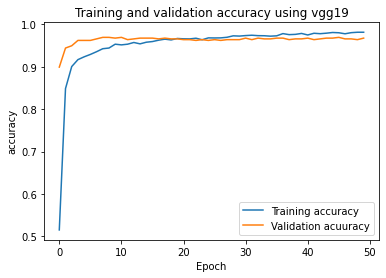

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(his.history["accuracy"], label='Training accuracy')
plt.plot(his.history["val_accuracy"], label='Validation acuuracy')
plt.title('Training and validation accuracy using vgg19')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()
plt.savefig("EYUEDU Training and validation Accuracy.png")

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix  

predict = model.predict(test_X, batch_size=BS)
predict = np.argmax(predict, axis=1)
print(classification_report(test_Y.argmax(axis=1), predict, labels=labelb.classes_))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       1.00      1.00      1.00        51
           2       0.98      0.94      0.96        50
           3       1.00      1.00      1.00        51
           4       1.00      1.00      1.00        50
           5       0.98      0.92      0.95        50
           6       0.92      0.90      0.91        51
           7       0.94      0.98      0.96        51
           8       1.00      1.00      1.00        51
           9       0.98      0.96      0.97        50
          10       0.89      0.94      0.91        51

    accuracy                           0.97       556
   macro avg       0.97      0.97      0.97       556
weighted avg       0.97      0.97      0.97       556



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f398b941d90>)

<Figure size 432x288 with 0 Axes>

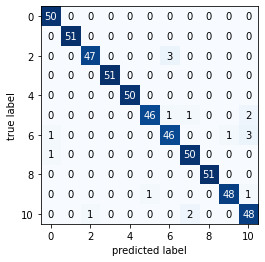

In [19]:
cm = confusion_matrix(test_Y.argmax(axis=1), predict, labels=labelb.classes_)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm)

In [1]:
model.save('EYUEDU_model11.h5')

NameError: ignored